# <center> **Stream Processing-ASSIGNMENT 2** </center>

#### Group No: 08

#### **Paper:** https://archive.ics.uci.edu/ml/datasets/parkinsons

#### Problem Statement:
The given dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson’s disease (PD). Each column in the table is a particular voice measure, and each row corresponds to one of 195 voice recordings from these individuals (“name” column). The main aim of the data is to discriminate healthy people from those with Parkinson’s Disease, according to the “status” column which is set to 0 for healthy and 1 for PD. Identify the optimum no of neighbors and dimensions for your model. Justify if KNN model should be considered or not for the problem statement. Implementation of different models on divergent datasets will help you in understanding the advantages and disadvantages of the application of these noisy ML models in real-time situations.

# 1. Import Libraries/Dataset

In [ ]:
pip install ucimlrepo

Python interpreter will be restarted.
  Using cached ucimlrepo-0.0.7-py3-none-any.whl (8.0 kB)
Python interpreter will be restarted.


In [ ]:
# Import required packages
from ucimlrepo import fetch_ucirepo
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Importing the dataset through python

# Fetch dataset
parkinsons = fetch_ucirepo(id=174)

# data (as pandas dataframes)
dataset = parkinsons.data.original
headers = parkinsons.data.headers
X_set = parkinsons.data.features
y_set = parkinsons.data.targets
feature_info = parkinsons.variables

# 2. Data Visualization and Exploration

In [ ]:
# Convert the pandas dataframe to pyspark dataframe, because pyspark dataframe doesn't support visualization.
df_spark = spark.createDataFrame(dataset)
df_spark.show(5)
print(f"Dataset contains {df_spark.count()} rows and {len(df_spark.columns)} columns.")

+--------------+-------+--------+--------+-----------+-------------+--------+--------+----------+------------+--------------+------------+------------+--------+-----------+-------+------+------+--------+--------+---------+--------+--------+--------+
|          name|MDVP:Fo|MDVP:Fhi|MDVP:Flo|MDVP:Jitter|MDVP:Jitter.1|MDVP:RAP|MDVP:PPQ|Jitter:DDP|MDVP:Shimmer|MDVP:Shimmer.1|Shimmer:APQ3|Shimmer:APQ5|MDVP:APQ|Shimmer:DDA|    NHR|   HNR|status|    RPDE|     DFA|  spread1| spread2|      D2|     PPE|
+--------------+-------+--------+--------+-----------+-------------+--------+--------+----------+------------+--------------+------------+------------+--------+-----------+-------+------+------+--------+--------+---------+--------+--------+--------+
|phon_R01_S01_1|119.992| 157.302|  74.997|    0.00784|       7.0E-5|  0.0037| 0.00554|   0.01109|     0.04374|         0.426|     0.02182|      0.0313| 0.02971|    0.06545|0.02211|21.033|     1|0.414783|0.815285|-4.813031|0.266482|2.301442|0.284654|


In [ ]:
# Since the name of two features are same, renaming them
df_spark = df_spark.withColumnRenamed('MDVP:Jitter.1', 'MDVP_Jitter_abs')
df_spark = df_spark.withColumnRenamed('MDVP:Shimmer.1', 'MDVP_Shimmer_db')

In [ ]:
# Dropping Categorical feature 'name'
df_spark = df_spark.drop('name')

# Update Pandas dataframe
df_pd = df_spark.toPandas()

# Statistical Summary
df_pd.describe()

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP_Jitter_abs,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP_Shimmer_db,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [ ]:
# Shape of the dataset
print("Dataframe shape (rows, columns) = ", df_pd.shape)

Dataframe shape (rows, columns) =  (195, 23)


In [ ]:
# Check the shape of target ('status') variable
print("Target ('status') unique values count: ")
print(df_pd['status'].value_counts())

Target ('status') unique values count: 
1    147
0     48
Name: status, dtype: int64


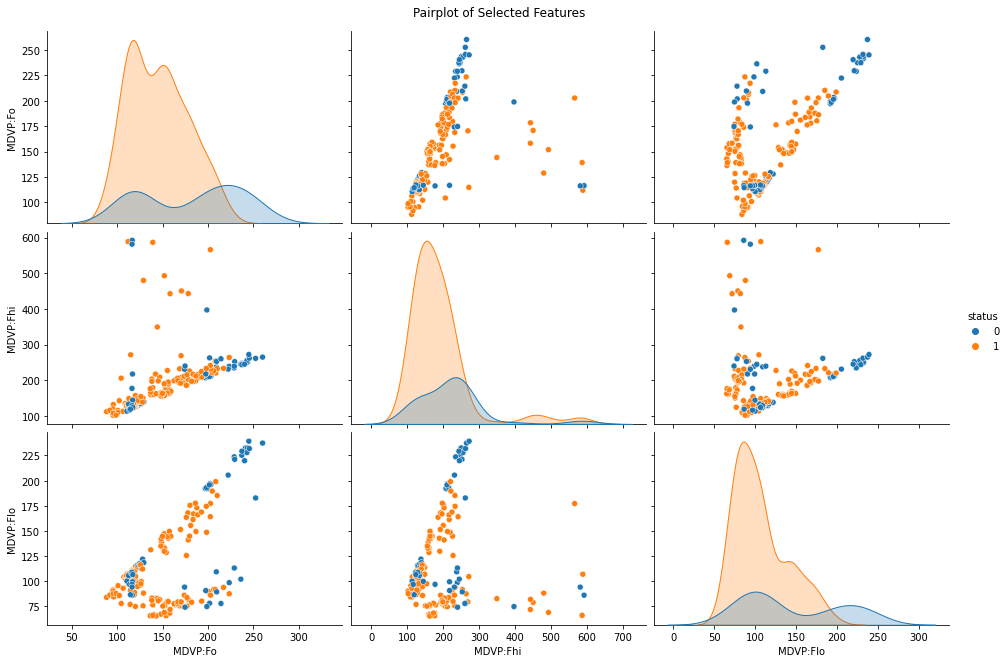

In [ ]:
# Exploring Pairplot for a few features under interest
sns.pairplot(df_pd[["MDVP:Fo", "MDVP:Fhi", "MDVP:Flo", "status"]], hue="status", height=3, aspect=1.5)
plt.suptitle("Pairplot of Selected Features", y=1.02)  # Adjust y for title placement
plt.show()

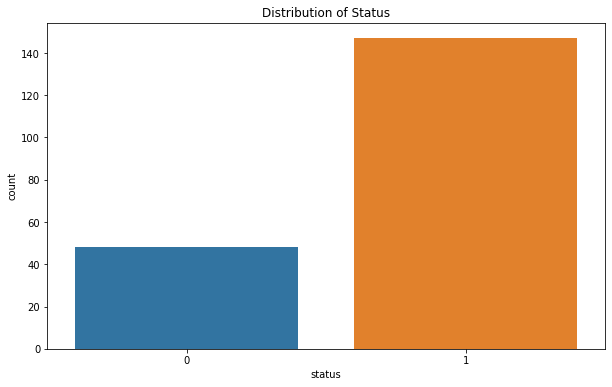

In [ ]:
# Plot distribution of the target variable 'status'
plt.figure(figsize=(10, 6))  
sns.countplot(x='status', data=df_pd)
plt.title("Distribution of Status")
plt.show()

In [ ]:
# Check for null values through pandas
df_pd.isnull().sum()

Out[10]: MDVP:Fo            0
MDVP:Fhi           0
MDVP:Flo           0
MDVP:Jitter        0
MDVP_Jitter_abs    0
MDVP:RAP           0
MDVP:PPQ           0
Jitter:DDP         0
MDVP:Shimmer       0
MDVP_Shimmer_db    0
Shimmer:APQ3       0
Shimmer:APQ5       0
MDVP:APQ           0
Shimmer:DDA        0
NHR                0
HNR                0
status             0
RPDE               0
DFA                0
spread1            0
spread2            0
D2                 0
PPE                0
dtype: int64

In [ ]:
# Check for null values (missing_values column in below table) through python package exposed variable
# display(parkinsons.metadata)
display(feature_info)

name,role,type,demographic,description,units,missing_values
name,ID,Categorical,null,null,null,no
MDVP:Fo,Feature,Continuous,null,null,Hz,no
MDVP:Fhi,Feature,Continuous,null,null,Hz,no
MDVP:Flo,Feature,Continuous,null,null,Hz,no
MDVP:Jitter,Feature,Continuous,null,null,%,no
MDVP:Jitter,Feature,Continuous,null,null,Abs,no
MDVP:RAP,Feature,Continuous,null,null,null,no
MDVP:PPQ,Feature,Continuous,null,null,null,no
Jitter:DDP,Feature,Continuous,null,null,null,no
MDVP:Shimmer,Feature,Continuous,null,null,null,no


In [ ]:
# Definition for plotting histgram and boxplot
def plot_data(data, plot_type, grid_size, fig_size, y = None):
    fig = plt.figure(figsize = fig_size)
    column_names = data.select_dtypes(exclude='object').columns
    for i, column_name in enumerate(column_names):
        fig.add_subplot(grid_size[0], grid_size[1], i + 1)
        if plot_type == 'hist':
            plot = sns.histplot(data[column_name], kde = True, color = 'red')
        elif plot_type == 'boxplot':
             plot = sns.boxplot(y=data[column_name], x=y, color = 'red')
        else:
            raise ValueError("Input value for the parameter 'plot_type' should be 'hist' or 'boxplot'.")
        plot.set_xlabel(column_name, fontsize = 16)
    plt.tight_layout()

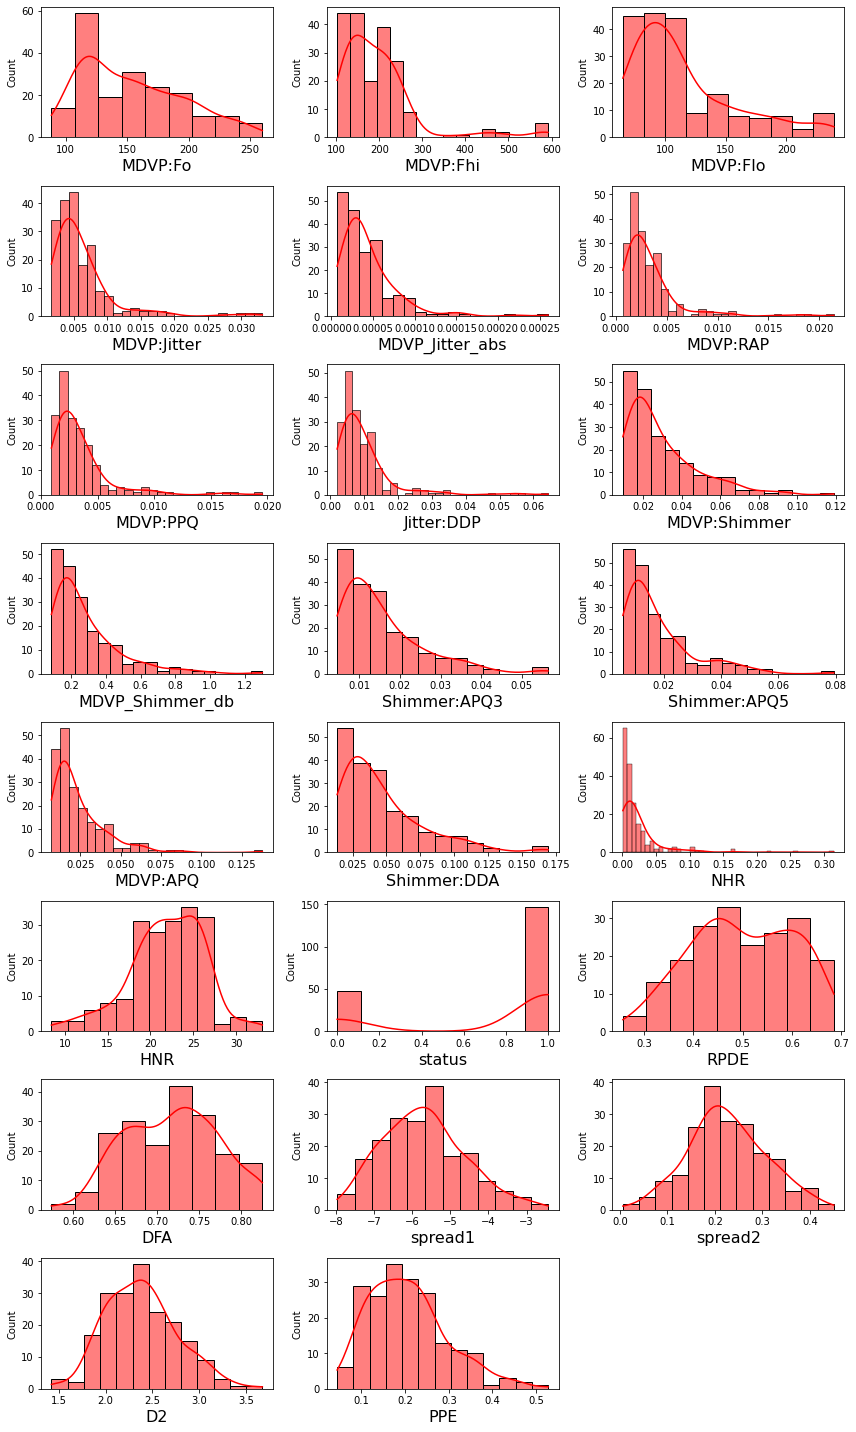

In [ ]:
plot_data(df_pd, plot_type = 'hist', grid_size = (8,3), fig_size = (12, 20))

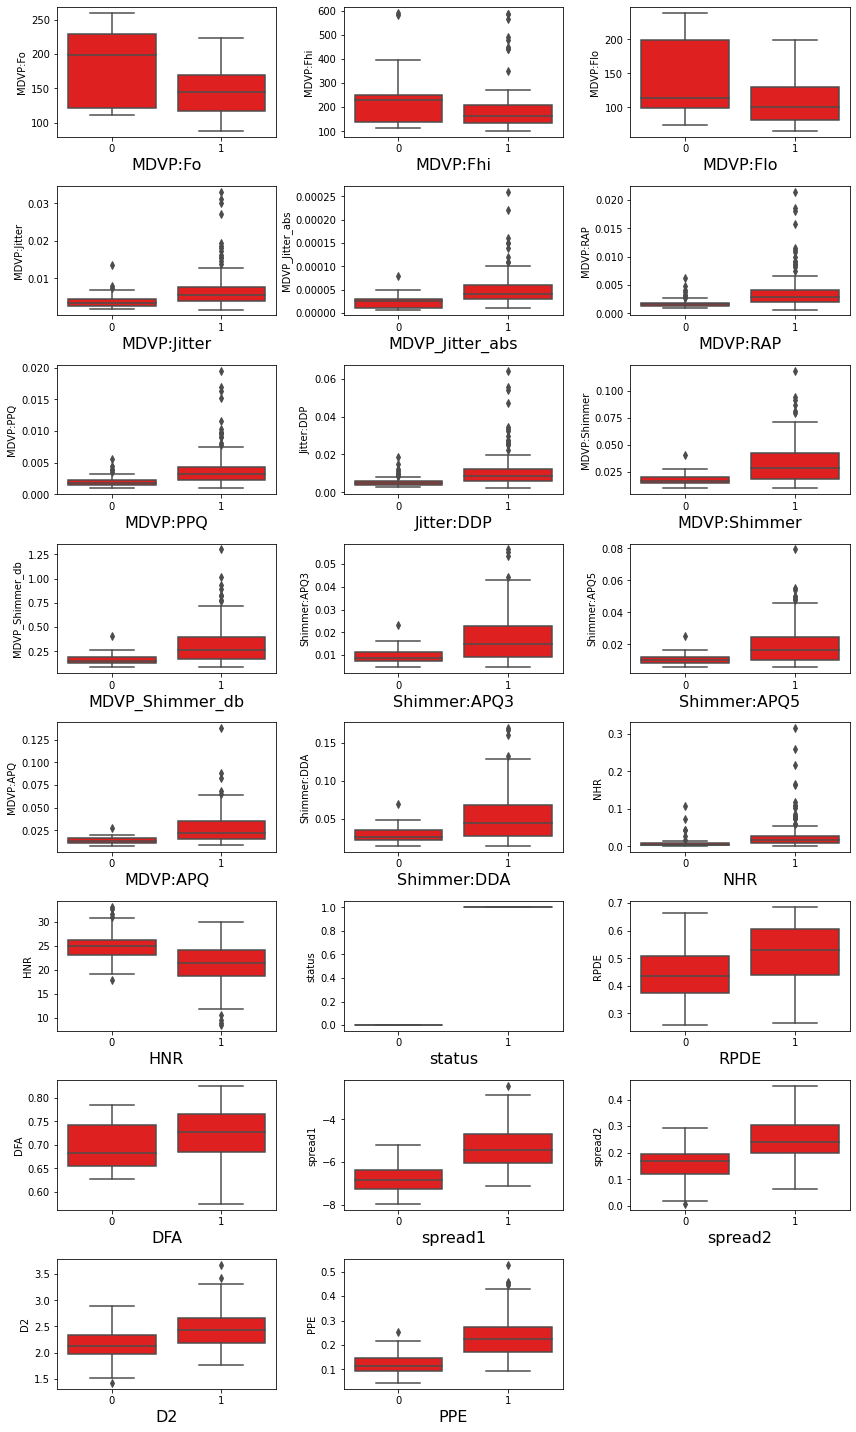

In [ ]:
# Box plot analysis
status = df_pd['status'].to_numpy()
plot_data(df_pd, y=status, plot_type = 'boxplot', grid_size = (8,3), fig_size = (12, 20))

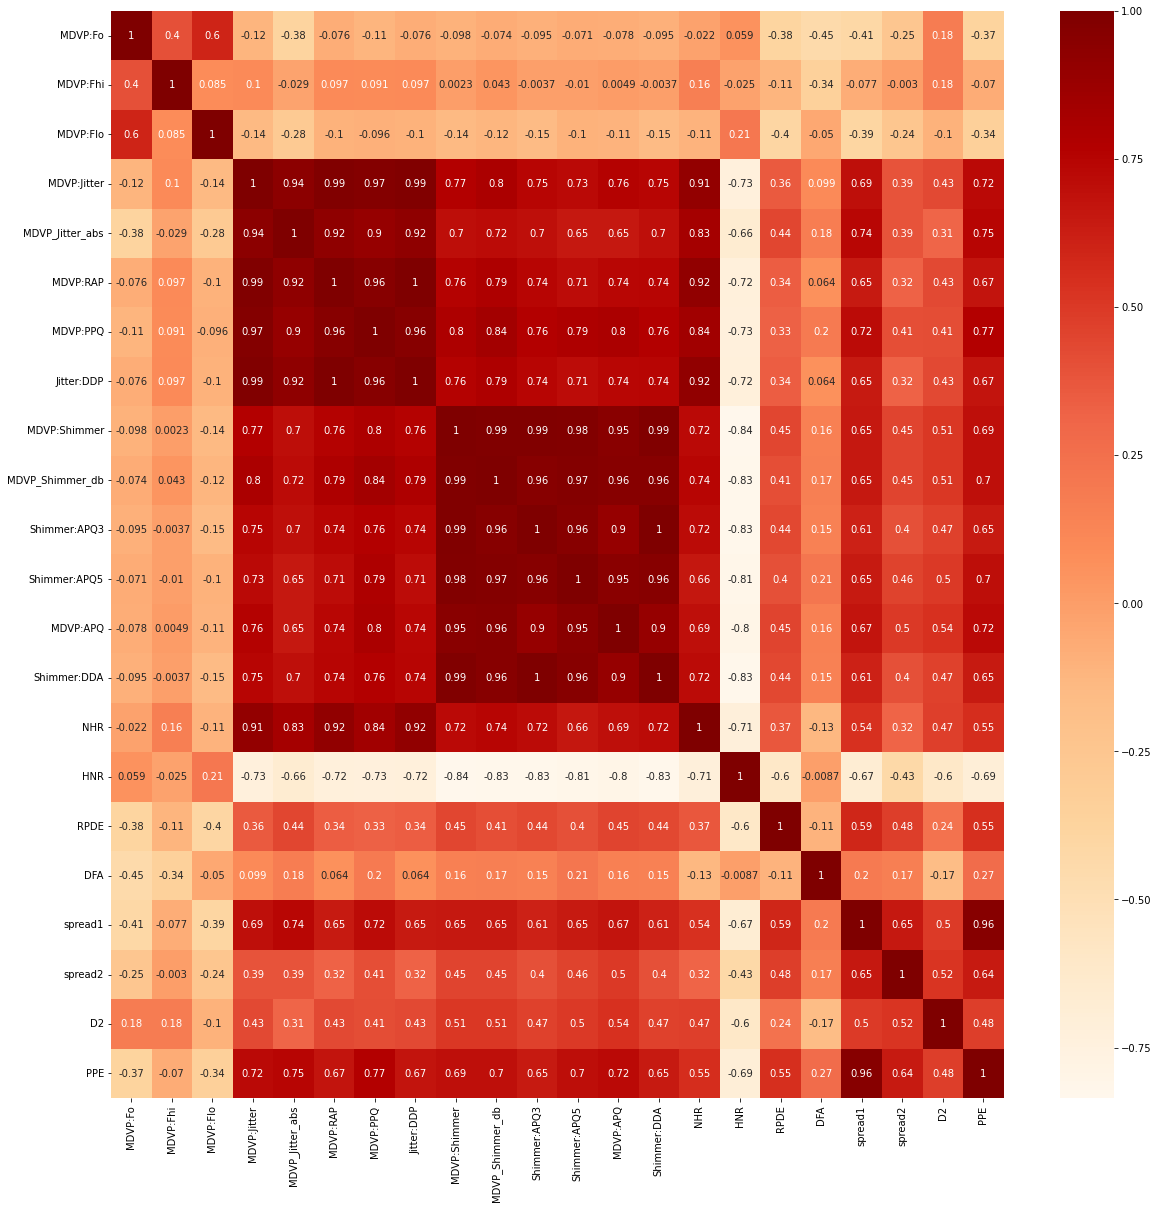

In [ ]:
# Plot for visualizing correlation between features
correl = df_pd.drop(columns='status').corr()
plt.figure(figsize=(20,20))
sns.heatmap(correl, annot=True,cmap='OrRd')
plt.show()

## Insights from Visualization

- The dataset contains more individuals diagnosed with Parkinson’s disease than healthy ones.
- Certain features exhibit strong correlations, suggesting possible redundancy in the data.
  But since the dataset is very small and dropping any feature would affect the model performance. Hence we are deciding to retain all the features
- Some features have noticeable outliers, which may require preprocessing to improve model performance.


# 3. Data Pre-processing & Cleaning

In [ ]:
# Outlier removal

# Compute Q1, Q3, and IQR for each column except 'status'
numeric_cols = [col for col in df_spark.columns if col not in ['status']]
bounds = {}

for feature in numeric_cols:
    q1, q3 = df_spark.approxQuantile(feature, [0.25, 0.75], 0.01)  # Approximate quantiles for large datasets
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    bounds[feature] = (lower_bound, upper_bound)

# Apply outlier filtering in PySpark
for feature, (lower, upper) in bounds.items():
    df_spark = df_spark.filter((col(feature) >= lower) & (col(feature) <= upper))

# Print new data shape after outlier removal
print(f"Data shape after outlier removal: ({df_spark.count()}, {len(df_spark.columns)})")


Data shape after outlier removal: (150, 23)


In [ ]:
# Update the preprocessed spark dataframe to pandas dataframe for visualization
df_pd = df_spark.toPandas()

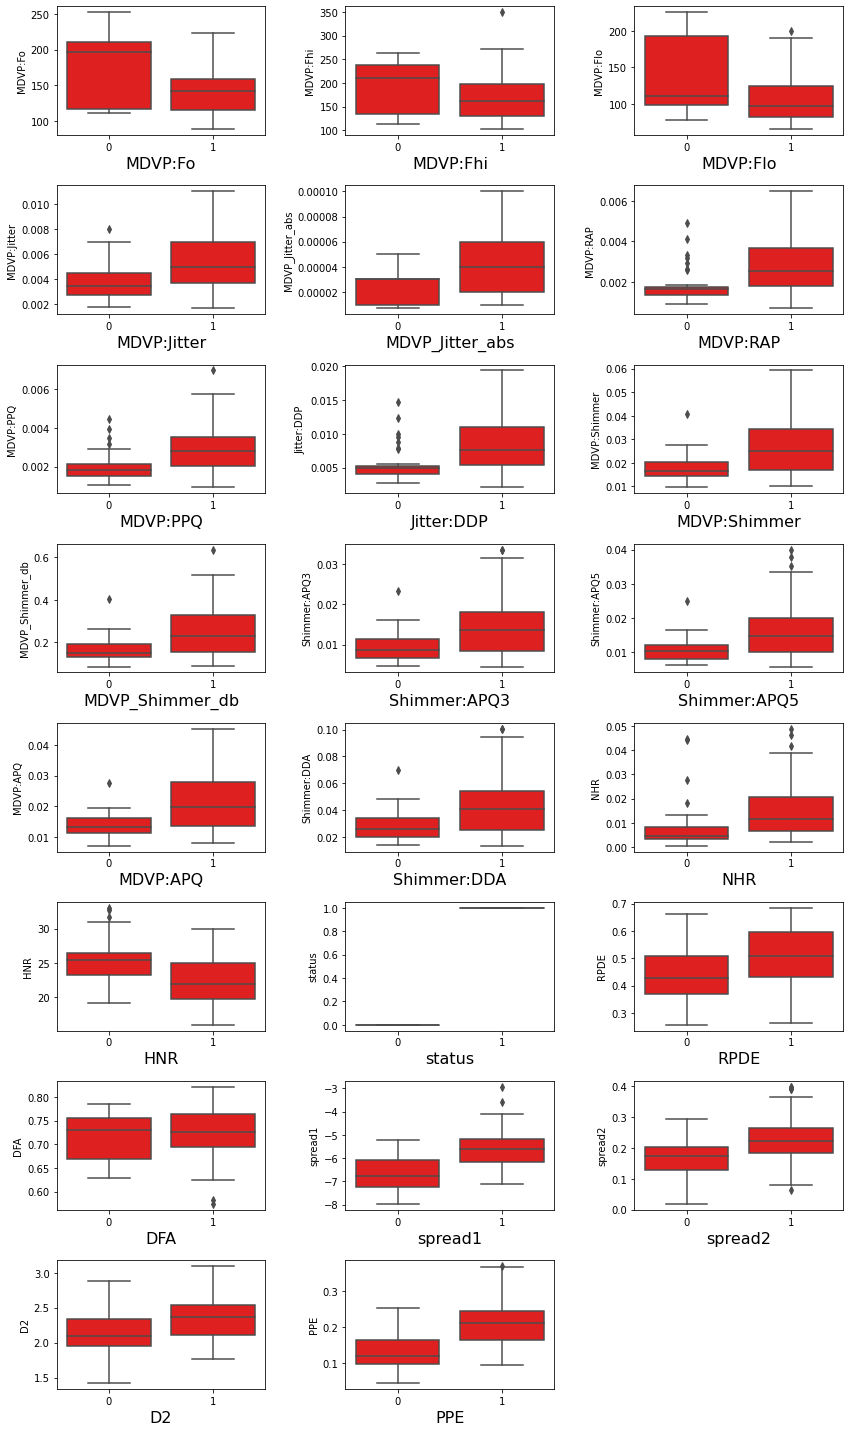

In [ ]:
# Boxplot after outlier removal
status = df_pd['status'].to_numpy()
plot_data(df_pd, y=status, plot_type = 'boxplot', grid_size = (8,3), fig_size = (12, 20))

# 4. Data Preparation

In [ ]:
# Split the target feature from spark dataframe
X = df_spark.drop('status') 
y = df_spark.select('status')


In [ ]:
# Display original dataset
display(df_spark.show(5))
print(f"Original dataset contains {df_spark.count()} rows and {len(df_spark.columns)} columns.")

+-------+--------+--------+-----------+---------------+--------+--------+----------+------------+---------------+------------+------------+--------+-----------+-------+------+------+--------+--------+---------+--------+--------+--------+
|MDVP:Fo|MDVP:Fhi|MDVP:Flo|MDVP:Jitter|MDVP_Jitter_abs|MDVP:RAP|MDVP:PPQ|Jitter:DDP|MDVP:Shimmer|MDVP_Shimmer_db|Shimmer:APQ3|Shimmer:APQ5|MDVP:APQ|Shimmer:DDA|    NHR|   HNR|status|    RPDE|     DFA|  spread1| spread2|      D2|     PPE|
+-------+--------+--------+-----------+---------------+--------+--------+----------+------------+---------------+------------+------------+--------+-----------+-------+------+------+--------+--------+---------+--------+--------+--------+
|119.992| 157.302|  74.997|    0.00784|         7.0E-5|  0.0037| 0.00554|   0.01109|     0.04374|          0.426|     0.02182|      0.0313| 0.02971|    0.06545|0.02211|21.033|     1|0.414783|0.815285|-4.813031|0.266482|2.301442|0.284654|
|116.676| 137.871| 111.366|    0.00997|         

In [ ]:
# Display X dataset
display(X.show(5))
print(f"X dataset contains {X.count()} rows and {len(X.columns)} columns.")

+-------+--------+--------+-----------+---------------+--------+--------+----------+------------+---------------+------------+------------+--------+-----------+-------+------+--------+--------+---------+--------+--------+--------+
|MDVP:Fo|MDVP:Fhi|MDVP:Flo|MDVP:Jitter|MDVP_Jitter_abs|MDVP:RAP|MDVP:PPQ|Jitter:DDP|MDVP:Shimmer|MDVP_Shimmer_db|Shimmer:APQ3|Shimmer:APQ5|MDVP:APQ|Shimmer:DDA|    NHR|   HNR|    RPDE|     DFA|  spread1| spread2|      D2|     PPE|
+-------+--------+--------+-----------+---------------+--------+--------+----------+------------+---------------+------------+------------+--------+-----------+-------+------+--------+--------+---------+--------+--------+--------+
|119.992| 157.302|  74.997|    0.00784|         7.0E-5|  0.0037| 0.00554|   0.01109|     0.04374|          0.426|     0.02182|      0.0313| 0.02971|    0.06545|0.02211|21.033|0.414783|0.815285|-4.813031|0.266482|2.301442|0.284654|
|116.676| 137.871| 111.366|    0.00997|         9.0E-5| 0.00502| 0.00698|   

In [ ]:
# Display y/target dataset
display(y.show(5))
print(f"y dataset contains {y.count()} rows and {len(y.columns)} columns.")

+------+
|status|
+------+
|     1|
|     1|
|     1|
|     1|
|     1|
+------+
only showing top 5 rows

y dataset contains 150 rows and 1 columns.


In [ ]:
# Vectorize the features
assembler = VectorAssembler(inputCols=X.columns, outputCol="features")
df_spark = assembler.transform(df_spark).select("features", "status")

In [ ]:
# Displaying dataframe after Vectorization
df_spark.show(5)

+--------------------+------+
|            features|status|
+--------------------+------+
|[119.992,157.302,...|     1|
|[116.676,137.871,...|     1|
|[120.267,137.244,...|     1|
|[107.332,113.84,1...|     1|
|[95.73,132.068,91...|     1|
+--------------------+------+
only showing top 5 rows



In [ ]:
# Standardization of data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_spark)
df_spark = scaler_model.transform(df_spark).select("scaledFeatures", "status")

In [ ]:
# Train-Test Split
train_set, test_set = df_spark.randomSplit([0.8, 0.2], seed=42)

# 5. Model Building & Performance Evaluation

In [ ]:
# Define Classification Models relevant to this problem
models = {
    "Logistic Regression": LogisticRegression(featuresCol="scaledFeatures", labelCol="status"),
    "Decision Tree": DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="status"),
    "Random Forest": RandomForestClassifier(featuresCol="scaledFeatures", labelCol="status", numTrees=10)
}

In [ ]:
# Definition for evaluating the model performance
def model_evaluation(dataset):
    predictions_list=[]

    # Train and Evaluate Models
    for model_name, model in models.items():
        print(f"Training {model_name}...")

        trained_model = model.fit(train_set)
        predictions = trained_model.transform(dataset)
        predictions_list.append([model_name, predictions])
        
        evaluator = MulticlassClassificationEvaluator(labelCol="status", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)
        print(f"{model_name} Accuracy: {accuracy:.4f}")

        # Calculate Log Loss
        evaluator_log_loss = MulticlassClassificationEvaluator(labelCol="status", predictionCol="prediction", metricName="logLoss")
        log_loss_value = evaluator_log_loss.evaluate(predictions)
        print(f"{model_name} Log Loss: {log_loss_value:.4f}\n")

    return predictions_list

# Definition for displaying confusing matrix for each model
def display_confusion_matrix(predictions_list):
    for model_name, predictions in predictions_list:
        prediction_rdd = predictions.select("status", "prediction").rdd.map(lambda x: (float(x[1]), float(x[0])))
        metrics = MulticlassMetrics(prediction_rdd)
        print("\nConfusion Matrix for", model_name, ":")
        print (metrics.confusionMatrix())



In [ ]:
# Evaluating train set
predictions_list = model_evaluation(train_set)
display_confusion_matrix(predictions_list)

Training Logistic Regression...
Logistic Regression Accuracy: 0.8718
Logistic Regression Log Loss: 0.2437

Training Decision Tree...
Decision Tree Accuracy: 0.9915
Decision Tree Log Loss: 0.0192

Training Random Forest...
Random Forest Accuracy: 0.9744
Random Forest Log Loss: 0.1408



/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Confusion Matrix for Logistic Regression :
DenseMatrix([[19.,  8.],
             [ 7., 83.]])

Confusion Matrix for Decision Tree :
DenseMatrix([[27.,  0.],
             [ 1., 89.]])

Confusion Matrix for Random Forest :
DenseMatrix([[24.,  3.],
             [ 0., 90.]])


In [ ]:
# Evaluating test set
predictions_list = model_evaluation(test_set)
display_confusion_matrix(predictions_list)

Training Logistic Regression...
Logistic Regression Accuracy: 0.7273
Logistic Regression Log Loss: 0.9024

Training Decision Tree...
Decision Tree Accuracy: 0.8182
Decision Tree Log Loss: 6.2798

Training Random Forest...
Random Forest Accuracy: 0.9091
Random Forest Log Loss: 0.3455


Confusion Matrix for Logistic Regression :
DenseMatrix([[ 3.,  6.],
             [ 3., 21.]])

Confusion Matrix for Decision Tree :
DenseMatrix([[ 4.,  5.],
             [ 1., 23.]])

Confusion Matrix for Random Forest :
DenseMatrix([[ 6.,  3.],
             [ 0., 24.]])


In [ ]:
# Definition for evaluating KNN model performance
def knn_model_evaluation(dataset, target):
    # Train KNN Model
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(dataset, target)

    # Predict and Evaluate KNN Model
    y_prediction = knn.predict(dataset)
    knn_accuracy = accuracy_score(target, y_prediction)
    print(f"KNN Accuracy: {knn_accuracy:.4f}")

    # Calculate Log Loss for KNN
    knn_log_loss = log_loss(target, knn.predict_proba(dataset))
    print(f"KNN Log Loss: {knn_log_loss:.4f}\n")

    return y_prediction

# Definition for displaying confusing matrix for KNN model
def knn_display_confusion_matrix(target, y_prediction):
    print("KNN Confusion Matrix:")
    print(confusion_matrix(target, y_prediction))

In [ ]:
# PySpark does not have a built-in K-Nearest Neighbors (KNN) algorithm in its MLlib library.
# Hence, KNeighborsClassifier from scikit-learn package can be used by converting the Spark DataFrame to a Pandas DataFrame and then using the Pandas DataFrame for training and prediction for our analysis.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

# Ignoring deprecated warning
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

# Convert Spark DataFrame to Pandas DataFrame for KNN
train_pd = train_set.toPandas()
test_pd = test_set.toPandas()

# Separate features and labels
X_train = np.array(train_pd["scaledFeatures"].tolist())
y_train = train_pd["status"].values
X_test = np.array(test_pd["scaledFeatures"].tolist())
y_test = test_pd["status"].values

In [ ]:
# Evaluating train set
predictions = knn_model_evaluation(X_train, y_train)
knn_display_confusion_matrix(y_train, predictions)

KNN Accuracy: 0.9145
KNN Log Loss: 0.1816

KNN Confusion Matrix:
[[22  5]
 [ 5 85]]


In [ ]:
# Evaluating test set
predictions = knn_model_evaluation(X_test, y_test)
knn_display_confusion_matrix(y_test, predictions)

KNN Accuracy: 0.8485
KNN Log Loss: 0.2993

KNN Confusion Matrix:
[[ 4  5]
 [ 0 24]]


# Conclusion & Inference
- We have evaluated accuracy against Logistic Regression, Decision Tree, Random forest & KNN models and observed that Random forest has highest accuracy.

- KNN can be considered for this type of problem. However, Pyspark doesn't support built-in KNN model. Hence scikit learn KNN package is used for our analysis.

- From the confusion matrix, we see that False-Positive & False-Negative counts are less compared to True-Positives & True-Negatives from all the model evaluation results.

- From 'Random Forest' confusion matrix, False-Positive & False-Negative counts are less when compared with other models!